## Settings

In [1]:
# Coordinates of interest
pangong = (33.7595, 78.6674)
delhi = (28.7041, 77.1025)
assam = (27.5010, 95.3693)
vizag = (17.45190,83.1232)

china_south = (21.8404, 107.8487)

china = (35.25, 103.75)
china_lat_margin = 19.5  # lat 15.75 - 54.75 ->  35.25 +- 19.5
china_lon_margin = 11.5  # lon 72.25 - 135.25 -> 103.75 +- 31.5
# china data source https://www.researchgate.net/figure/Latitude-and-longitude-boundaries-for-all-eight-regions-over-China-with-the-region_tbl1_273200022

In [2]:
folder = r'ch4'  # folder where '.nc' files are stored
timeline = 29  # specify timeline from latest file (in days). 
cent_latlon = assam  # central latitude ang longitude 
lat_margin = 40 # latitude margin   
lon_margin = 40  # longitude margin   # debug: not using china_lon/lat because it takes a while to process

In [3]:
bandwidth = 6
window = 1  # days over which the moving cluster is calculated

## Combine Orbits

In [4]:
import os
import numpy as np
from netCDF4 import Dataset

def getdate(st):# function to read the timestamp out of the filename
    str1=st[20:38]
    y=str1[0:4]
    m=str1[4:6]
    d=str1[6:8]
    h=str1[9:11]
    if int(h)<12:
        h='00'
    else:
        h='00'
    mn='00'
    s='00'
    return y+'-'+m+'-'+d+'T'+h+':'+mn+':'+s


def create_time_frames(n_days, directory, cent_latlon, latmar, lonmar, access_var="methane_mixing_ratio"):
    # This function combines data of orbits that are measured on the same day
    # Use n_days to select the time frame  (from now until now-ndays)    
    # Use cent_latlon, latmar, lonmar to specify region    
    
    # save data per day [lat, long, sensordata] for the given time frame variables
    # (use for normalise the output array for folium visulation)
    data_per_day=list() 
    dates=list()
        
    # Define a square using lat and lon
    min_lat=cent_latlon[0]-latmar
    max_lat=cent_latlon[0]+latmar
    min_lon=cent_latlon[1]-lonmar
    max_lon=cent_latlon[1]+lonmar
    
    dirlist=os.listdir(directory)
    # Put all different dates in datelist
    datelist=list() 
    for i in dirlist:
        d=getdate(i)
        if d not in datelist:
            datelist.append(d)    
    datelist.sort()
    
    # Loop over each data (from now-n-days until now)
    for j in range(len(datelist)-n_days, len(datelist)):        
        points_l=list()        
        # Loop over files to find same date
        for i in range(len(dirlist)): 
            if getdate(dirlist[i]) == datelist[j]:
                
                # Get stored file
                ncd_file=Dataset(directory+'/'+ dirlist[i],'r')
                # Read file data
                lat = ncd_file.groups['PRODUCT'].variables['latitude'][0,:,:]
                lon = ncd_file.groups['PRODUCT'].variables['longitude'][0,:,:]
                no2_data=np.array(ncd_file.groups['PRODUCT'].variables[access_var][0,:,:])
                fill_value=ncd_file.groups['PRODUCT'].variables[access_var]._FillValue
                # Flatten all data
                #no2_data[no2_data==fill_value]=0#Substituting Fill values with 0 for better mean calculation
                lat1=np.array(lat).flatten() # array of latitudes
                lon1=np.array(lon).flatten() #array of longitudes
                dat1=np.array(no2_data).flatten() # array of corresponding reading list where lat index is withing the given margins to access fewer elements in lon list    
                
                # Save data in points_l when lon and lan is in the range, fill value is thrown away
                ind_lat = np.where((lat1>min_lat) & (lat1<max_lat))[0]
                for i in ind_lat:
                    tlist=list()
                    if lon1[i]>min_lon and lon1[i]<max_lon and dat1[i] != fill_value:
                        tlist.append(lat1[i])            
                        tlist.append(lon1[i])
                        tlist.append(dat1[i])             
                        points_l.append(list(tlist))
                        
        # Save points_l to time frame
        data_per_day.append(points_l)
        dates.append(datelist[j]) 
    return data_per_day, dates

In [5]:
data_per_day, dates = create_time_frames(timeline, folder, cent_latlon, lat_margin, lon_margin)

## Calculate clusters

In [6]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, Birch, MiniBatchKMeans
from sklearn.neighbors import KernelDensity

def calc_mean_shift_clusters(data_per_day, dates, window=1, bandwidth=10, max_iter=1000):
    data_clusters=list()
    date_list=list()
    max_v=0
    min_v=1000000
   
    # Loop to calculate each window
    for i in range(window,len(data_per_day)):
        print('window day '+dates[i-window][0:10]+' to '+dates[i][0:10]) # debug: print progress so far
        
        #k_m = KMeans(n_clusters=n_clus, random_state=0).fit(np.array(data_per_day[i]))
        #data_clusters.append(k_m.cluster_centers_)
        
        # Calculate each cluster 
        n_l = list()
        for w in range(i-window, i):
            n_l= n_l + data_per_day[w]            
        # simple explanation of the algorithm https://www.youtube.com/watch?v=TMPEujQrY70 
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, max_iter=max_iter, cluster_all=True)
        ms.fit(n_l)
        cluster_centers = ms.cluster_centers_     
        #print(len(cluster_centers))
        
        # Save cluster results
        cluster = list()
        for center in cluster_centers:
            cluster.append(list(center))
            if center[2] > max_v:
                max_v = center[2]
            if center[2] < min_v:
                min_v = center[2]
                
        data_clusters.append(cluster)
        date_list.append(dates[i])
    return data_clusters, date_list, max_v, min_v


def normalise(i,min_val, max_val):
    if i >max_val:
        return 1
    if i <min_val:
        return 0
    else:
        return (i-min_val)/(max_val-min_val)
    
    
def normalise_list(data,min_val,max_val):
    new_df=list()
    for i in range(0,len(data)):
        new_l=list()
        for j in range(0,len(data[i])): 
            new_l.append(list([data[i][j][0],data[i][j][1],normalise(data[i][j][2],min_val,max_val)]))
        new_df.append(new_l)
    return new_df



In [7]:
cluster_data = calc_mean_shift_clusters(data_per_day, dates, window, bandwidth) 
clustered_dataframes, time_line, max_v, minv = cluster_data

window day 2020-05-11 to 2020-05-12
window day 2020-05-12 to 2020-05-13
window day 2020-05-13 to 2020-05-14
window day 2020-05-14 to 2020-05-15
window day 2020-05-15 to 2020-05-16
window day 2020-05-16 to 2020-05-17
window day 2020-05-17 to 2020-05-18
window day 2020-05-18 to 2020-05-19
window day 2020-05-19 to 2020-05-20
window day 2020-05-20 to 2020-05-21
window day 2020-05-21 to 2020-05-22
window day 2020-05-22 to 2020-05-23
window day 2020-05-23 to 2020-05-24
window day 2020-05-24 to 2020-05-25
window day 2020-05-25 to 2020-05-26
window day 2020-05-26 to 2020-05-27
window day 2020-05-27 to 2020-05-28
window day 2020-05-28 to 2020-05-29
window day 2020-05-29 to 2020-05-30
window day 2020-05-30 to 2020-05-31
window day 2020-05-31 to 2020-06-01
window day 2020-06-01 to 2020-06-02
window day 2020-06-02 to 2020-06-03
window day 2020-06-03 to 2020-06-04
window day 2020-06-04 to 2020-06-05
window day 2020-06-05 to 2020-06-06
window day 2020-06-06 to 2020-06-07
window day 2020-06-07 to 202

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def show_timeframein3D(data,date):
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111, projection='3d')
    for i in data:
        ax.scatter(i[0],i[1],i[2])
    ax.set_title("Scatter-Plot for date "+date[0:10])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Weights')
    plt.show()


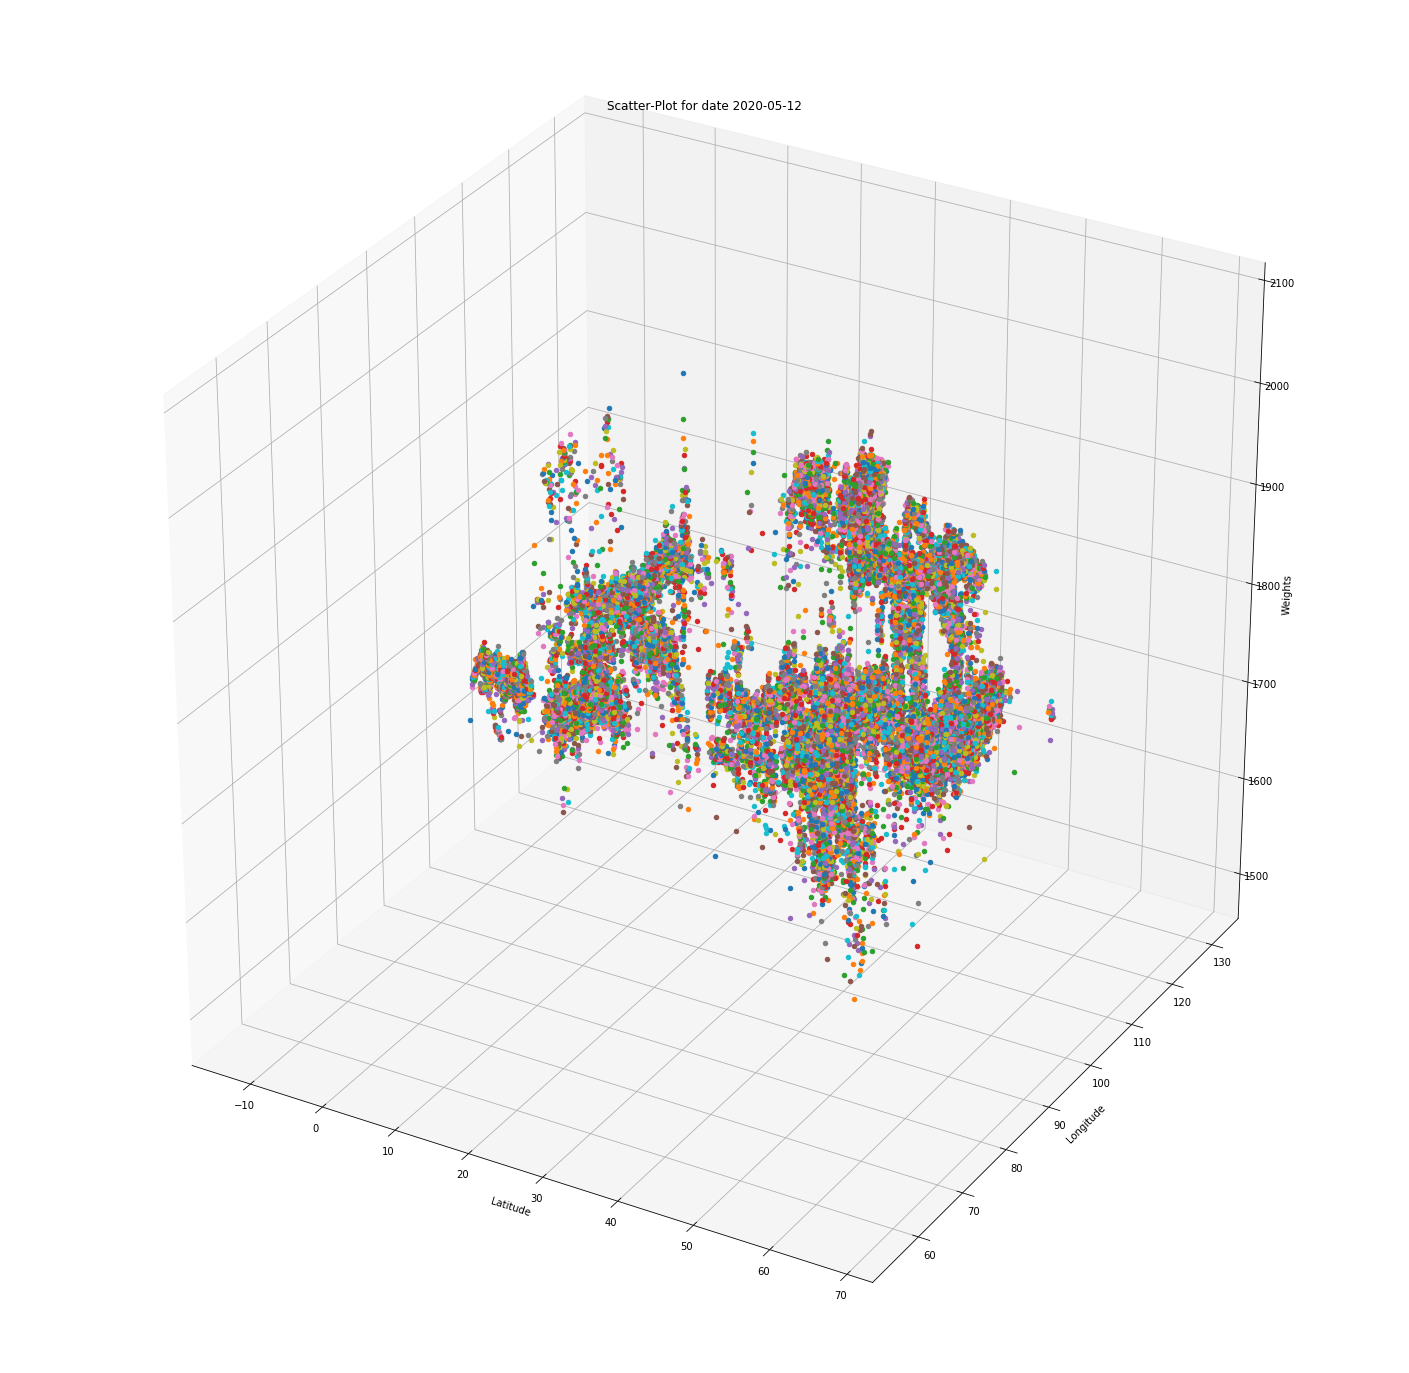

In [10]:
ind=0
show_timeframein3D(data_per_day[ind+window],dates[ind+window])

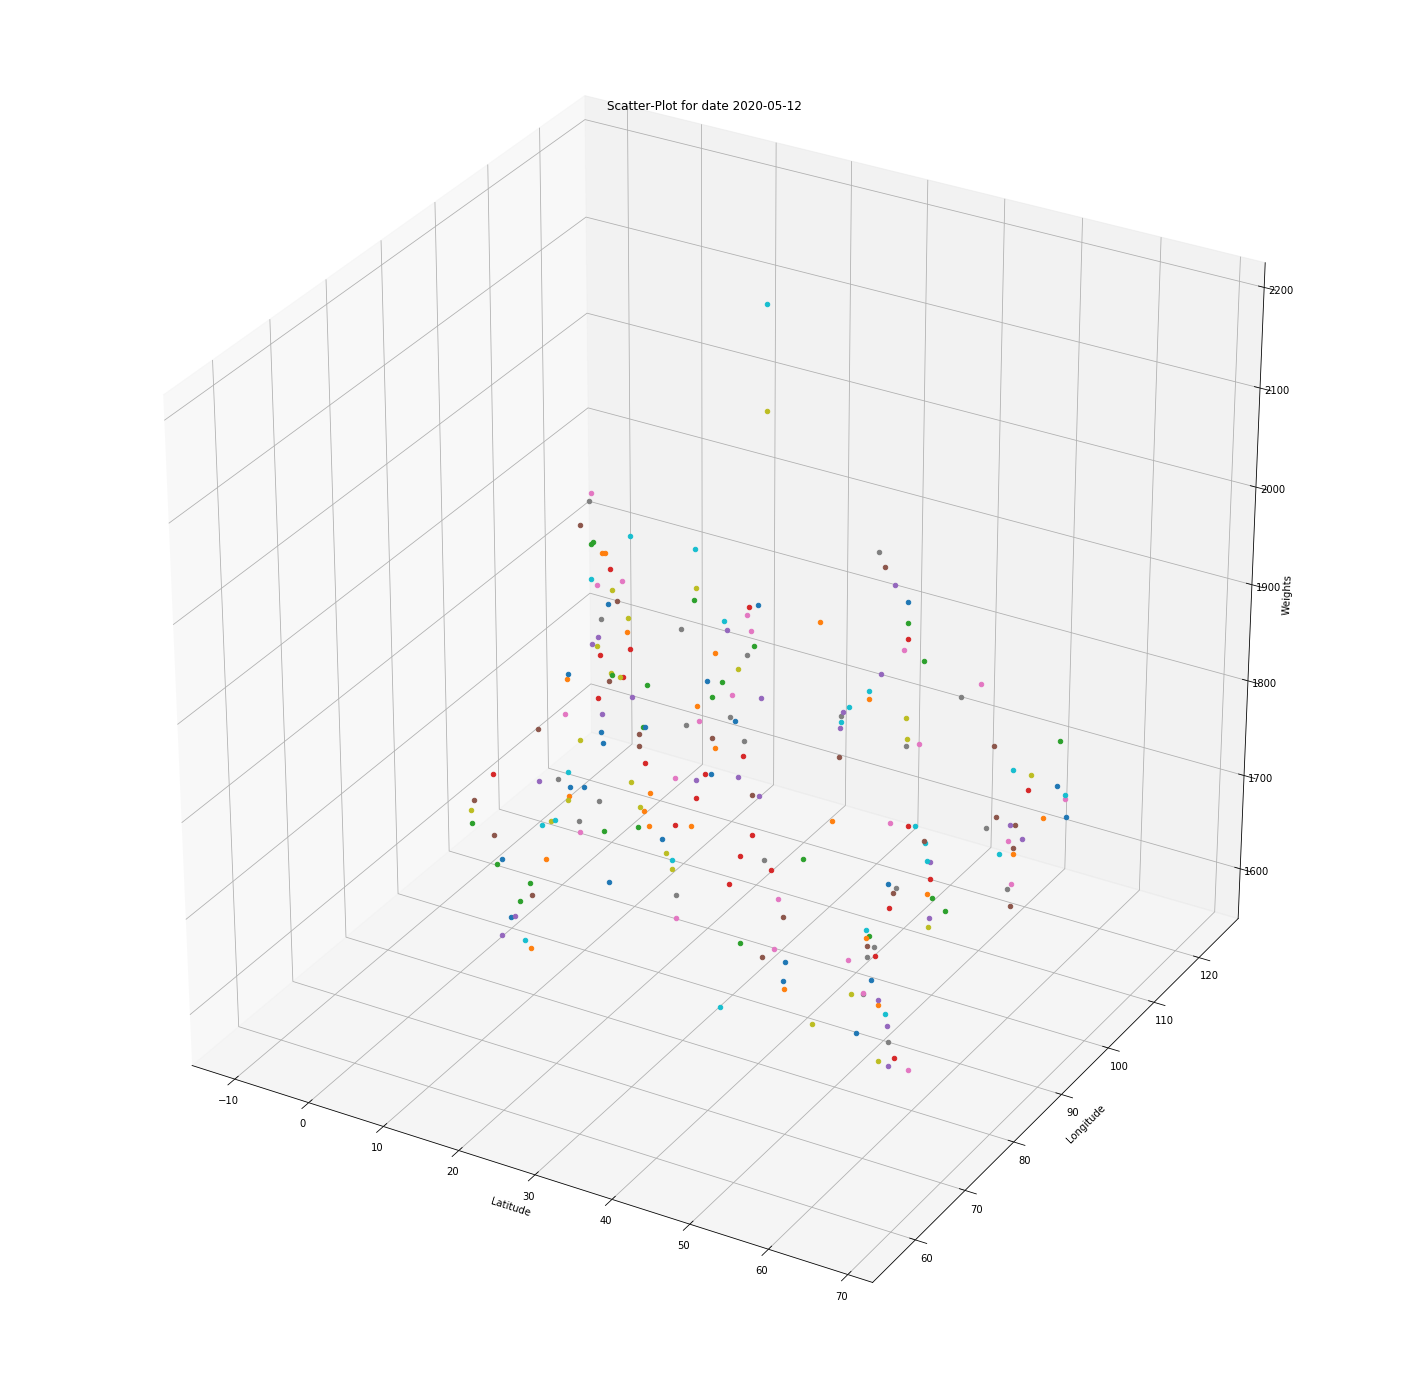

In [11]:
show_timeframein3D(clustered_dataframes[ind],time_line[ind])

In [12]:
clustered_dataframes_normalised = normalise_list(clustered_dataframes, max_v, minv)

## Visualization

### Interactive cluster map
map plot options: <br>
0: Satellite
1: openstreetmap
2: Stamen Terrain
3: cartodbdark_matter
4: cartodbpositron
5: stamenwatercolor
6: stamentoner

In [13]:
#import mplleaflet
import folium 
from folium.plugins import HeatMapWithTime

def show_map(data,index,cent_latlon,option):#options 0=satellite
    token = "pk.eyJ1IjoiYXN0ZXJpeDEzIiwiYSI6ImNrOWlob2l3MjAzNGwzbW9ieDN3dHFwbnMifQ.UBvs27qqJRNqfvjAIy1J2Q" # your mapbox token
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    map_options=["openstreetmap","Stamen Terrain","cartodbdark_matter","cartodbpositron","stamenwatercolor","stamentoner"]
    if option==0:
        m= folium.Map(location=[cent_latlon[0],cent_latlon[1]],tiles=tileurl, attr='Mapbox')
    else:
        m= folium.Map(location=[cent_latlon[0],cent_latlon[1]],tiles=map_options[option-1])    
    m.add_child(folium.LatLngPopup())
    gradie={0.1:'skyblue',0.2: 'blue', 0.3: 'darkblue', 0.4: 'green',            
            0.5: 'yellow',0.6: 'lime',0.7: 'orange',0.80: 'red'}
    HeatMapWithTime(data,index=index,auto_play=True,max_opacity=1,min_opacity=0.1, radius=13, gradient=gradie).add_to(m)
    return m

show_map(clustered_dataframes_normalised, time_line, cent_latlon, option=1)

#### Original Dataframes 

### Dataframes With Their Corresponding clusters for a particular day

In [ ]:
# Plot data points of one day containing a methane value

def show_Onedayvalue_map(data,clusters,index,cent_latlon,option):#options 0=satellite
    
    token = "pk.eyJ1IjoiYXN0ZXJpeDEzIiwiYSI6ImNrOWlob2l3MjAzNGwzbW9ieDN3dHFwbnMifQ.UBvs27qqJRNqfvjAIy1J2Q" # your mapbox token
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    map_options=["openstreetmap","Stamen Terrain","cartodbdark_matter","cartodbpositron","stamenwatercolor","stamentoner"]
    print("DATA AVAILABLE FOR "+index[0:10])
    print("EXCLUDING FILL VALUES")
    if option==0:
        m= folium.Map(location=[cent_latlon[0],cent_latlon[1]],tiles=tileurl, attr='Mapbox')
    else:
        m= folium.Map(location=[cent_latlon[0],cent_latlon[1]],tiles=map_options[option-1])  
    for dat in data:
        # Use Circle (radius in meters) or CircleMarker (radius in pixels)
        folium.CircleMarker([dat[0],dat[1]], radius=5, color='blue', fill=True).add_to(m)
    for dat in clusters:
        # Use Circle (radius in meters) or CircleMarker (radius in pixels)
        folium.CircleMarker([dat[0],dat[1]], radius=5, color='red', fill=True).add_to(m)
    return m
    
    
ind=13
show_Onedayvalue_map(data_per_day[ind+window-1],clustered_dataframes[ind], dates[ind+window-1], cent_latlon, option=1)

DATA AVAILABLE FOR 2020-05-24
EXCLUDING FILL VALUES


### Plot concentration trends

In [ ]:
import matplotlib.pyplot as plt
import reverse_geocoder as rg # pip install reverse_geocoder
import io

def plot_average_ch4_in_area(data_per_day, dateline,cent_latlon,latmar,lonmar):
    avglist=list()
    max_list=list()
    perct_list=list()
    for j in data_per_day:
        sum1=0
        max_v=0
        coun=1
        perlist=[]
        perlist.append(0)
        for i in j:
            if i[0]>cent_latlon[0]-marlat and i[0]<cent_latlon[0]+marlat and i[1]>cent_latlon[1]-marlon and i[1]<cent_latlon[1]+marlon:
                sum1+=i[2]
                coun+=1
                if i[2]>max_v:
                    max_v=i[2]                
                perlist.append(i[2])
        pert=np.sort(perlist)
        avglist.append(sum1/coun)
        max_list.append(max_v)
        perct_list.append(pert[int(0.8*len(perlist))])
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.plot(dateline,avglist,  color='tab:blue', marker='+',label="CH4_average")
    plt.plot(dateline,max_list, color='tab:red',marker='x',linestyle=':',label="CH4_maximum")
    plt.plot(dateline,perct_list ,color='tab:orange',marker='o',linestyle='--',label="80th percile")
    plt.xlabel("dates",fontsize=25)
    plt.ylabel("CH4 concentration",fontsize=25)
    geo = rg.RGeocoder(mode=2, verbose=True, stream=io.StringIO(open('border/rg_cities1000.csv', encoding='utf-8').read()))
    coordinates=(cent_latlon[0],cent_latlon[1]),
    results = geo.query(coordinates)
    str1=results[0]['name']+','+results[0]['admin1']+','+results[0]['cc']
    plt.title("CH4 concentration trend at "+str1,fontsize=25)
    plt.gcf().autofmt_xdate()
    plt.legend(fontsize=10)
    plt.show()
    return  True

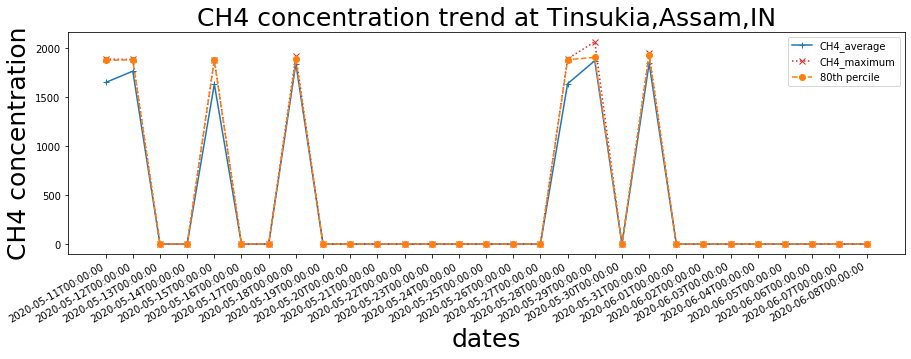

True

In [17]:
marlat = 1.0
marlon = 1.0
center = assam

plot_average_ch4_in_area(data_per_day, dates, center, marlat, marlon)